In [4]:
### This script checks which interactions are marked by ATAC and H3K27ac at PIRs

library(data.table)
library(Chicago)
library(ggplot2)
library(eulerr)


# load epigenetic data

atac <- fread("/rds/general/user/malyshev/home/miniPCHiC/hILCs/spivakov_pchic_ILC_CD4/data/peaks/ATAC/ILC3_ATAC_peaks.bed")
k27ac <- fread("/rds/general/user/malyshev/home/miniPCHiC/hILCs/spivakov_pchic_ILC_CD4/data/peaks/CHIP/ILC3_H3K27ac_peaks.bed")

# load rmaps
rmap_fres <- fread("/rds/general/user/malyshev/home/spivakov_analysis_live/Design/Human_DpnII_binsize1500_maxL75K/hg38_dpnII.rmap")
rmap_5kb <- fread("/rds/general/user/malyshev/home/spivakov_analysis_live/Design/Human_hg38_bin5K_sol_baits/human_DpnII_5K_sol_baits.rmap")
rmap_20kb <- fread("/rds/general/user/malyshev/home/spivakov_analysis_live/Design/Human_hg38_bin20K_sol_baits/hg38_dpnII_20kb_sol_baits.rmap")

## function for merging epigenetic data with rmap

epirmap <- function(epiprof, rmap_fres, rmap_5kb, rmap_20kb, overlap_by){
  
  # overlap_by: "summit" or "region"
  
  if (overlap_by == "summit"){
      # define middle point of a peak
      epiprof[,mid := (V2 + V3) /2]
      epiprof[,mid_2 := (V2 + V3) /2]
      epiprof <- epiprof[,c("V1", "V2", "V3", "mid", "mid_2")]
      epiprof[,V1 := gsub("chr", "", V1)]
  }else{
      # define middle point of a peak
      epiprof[,mid := V2]
      epiprof[,mid_2 := V3]
      epiprof <- epiprof[,c("V1", "V2", "V3", "mid", "mid_2")]
      epiprof[,V1 := gsub("chr", "", V1)]
  }

  
  # assign peaks to fres rmap bins by summit
  setkey(epiprof, V1, mid, mid_2)
  setkey(rmap_fres, V1, V2, V3)
  epi_rmap <- foverlaps(epiprof, rmap_fres, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))
  epi_rmap <- epi_rmap[,c("V1", "mid", "mid_2", "V4")]
  setnames(epi_rmap, "V4", "fres_ID")
  
  # assign peaks to 5kb rmap bins by summit
  setkey(epi_rmap, V1, mid, mid_2)
  setkey(rmap_5kb, V1, V2, V3)
  epi_rmap <- foverlaps(epi_rmap, rmap_5kb, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))
  epi_rmap <- epi_rmap[,c("V1", "mid", "mid_2", "fres_ID", "V4")]
  setnames(epi_rmap, "V4", "5kb_ID")
  
  # assign atac peaks to 20kb rmap bins by summit of a peak
  setkey(epi_rmap, V1, mid, mid_2)
  setkey(rmap_20kb, V1, V2, V3)
  epi_rmap <- foverlaps(epi_rmap, rmap_20kb, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))
  epi_rmap <- epi_rmap[,c("V1", "mid", "mid_2", "fres_ID", "5kb_ID", "V4")]
  setnames(epi_rmap, "V4", "20kb_ID")
  
  return(epi_rmap)
}

atac_rmap <- epirmap(atac, rmap_fres, rmap_5kb, rmap_20kb, "summit")
k27ac_rmap <- epirmap(k27ac, rmap_fres, rmap_5kb, rmap_20kb, "summit")


# ## load the singificant interactions:
# ## the "sel" stands for score >=5
# ## loading ILC Chicago results
# ilc_fres <- readRDS("~/miniPCHiC/hILCs/hILCs_run2/Chicago/without_binning/hILC3_all_merged_Step2_corrected_weighting/data/hILC3_all_merged_Step2_corrected_weighting.Rds")
# ilc_5kb <- readRDS("~/miniPCHiC/hILCs/hILCs_run2/Chicago/with_binning/hILCs_all_merged_bin_Step2/data/hILCs_all_merged_bin_Step2.Rds")
# ilc_20kb <- readRDS("~/miniPCHiC/hILCs/hILCs_run2/Chicago/with_binning_20K/hILC3_20K_merged_Step2/data/hILC3_20K_merged_Step2.Rds")


# ### check if PIRs have ATAC or H3K27ac markers

# ilc_fres_x <- ilc_fres@x[score >= 5][,atac := ifelse(otherEndID %in% atac_rmap$fres_ID, "TRUE", "FALSE")]
# ilc_fres_x <- ilc_fres_x[,k27ac := ifelse(otherEndID %in% k27ac_rmap$fres_ID, "TRUE", "FALSE")]

# ilc_5kb_x <- ilc_5kb@x[score >= 5][,atac := ifelse(otherEndID %in% atac_rmap$'5kb_ID', "TRUE", "FALSE")]
# ilc_5kb_x <- ilc_5kb_x[,k27ac := ifelse(otherEndID %in% k27ac_rmap$'5kb_ID', "TRUE", "FALSE")]

# ilc_20kb_x <- ilc_20kb@x[score >= 5][,atac := ifelse(otherEndID %in% atac_rmap$'20kb_ID', "TRUE", "FALSE")]
# ilc_20kb_x <- ilc_20kb_x[,k27ac := ifelse(otherEndID %in% k27ac_rmap$'20kb_ID', "TRUE", "FALSE")]


# ## mark PIRs that have ATAC or H3K27ac peaks

# print("total number of interactions")
# nrow(ilc_fres_x) # 31003
# print("total number of unique PIRs")
# length(unique(ilc_fres_x$otherEndID)) # 28174
# print("number of unique fragres PIRs marked with ATAC")
# length(unique(ilc_fres_x[atac == TRUE]$otherEndID)) # 2614
# print("number of unique fragres PIRs marked with H3K27ac")
# length(unique(ilc_fres_x[k27ac == TRUE]$otherEndID)) # 1089
# print("number of unique fragres PIRs marked with H3K27ac or ATAC")
# length(unique(ilc_fres_x[k27ac == TRUE | atac == TRUE]$otherEndID)) # 3095

# # 5kb resolution

# print("total number of 5kb unique interactions")
# nrow(unique(ilc_5kb_x)) # 58632
# print("total number of unique PIRs")
# length(unique(ilc_5kb_x$otherEndID)) # 35812
# print("number of 5kb PIRs marked with ATAC")
# length(unique(ilc_5kb_x[atac == TRUE]$otherEndID)) # 10617
# print("number of 5kb PIRs marked with H3K27ac")
# length(unique(ilc_5kb_x[k27ac == TRUE]$otherEndID)) # 4043
# print("number of 5kb PIRs marked with H3K27ac or ATAC")
# length(unique(ilc_5kb_x[k27ac == TRUE | atac == TRUE]$otherEndID)) # 11822

# # 20kb resolution
# ilc_20kb_x[,atac := ifelse(otherEndID %in% atac_rmap$'20kb_ID', TRUE, FALSE)]
# ilc_20kb_x[,k27ac := ifelse(otherEndID %in% k27ac_rmap$'20kb_ID', "TRUE", "FALSE")]

# print("total number of 20kb unique interactions")
# nrow(unique(ilc_20kb_x)) # 17107
# print("total number of unique PIRs")
# length(unique(ilc_20kb_x$otherEndID)) # 10241
# print("number of fragres PIRs marked with ATAC")
# length(unique(ilc_20kb_x[atac == TRUE]$otherEndID)) # 5999
# print("number of fragres PIRs marked with H3K27ac")
# length(unique(ilc_20kb_x[k27ac == TRUE]$otherEndID)) # 2187
# print("number of fragres PIRs marked with H3K27ac or ATAC")
# length(unique(ilc_20kb_x[k27ac == TRUE | atac == TRUE]$otherEndID)) # 6360



In [2]:
fwrite(ilc_fres_x, "ILC3_CHiCAGO_score5_fragment_resolution.txt", sep = "\t", scipen = 999)
fwrite(ilc_5kb_x, "ILC3_CHiCAGO_score5_5kb_solitary_bait_resolution.txt", sep = "\t", scipen = 999)
fwrite(ilc_20kb_x, "ILC3_CHiCAGO_score5_20kb_solitary_bait_resolution.txt", sep = "\t", scipen = 999)

In [6]:
#### integrate with blueprint
library(data.table)
regbuild <- fread("~/spivakov_analysis_live/ensembl/Ensembl96_GRCh38_RegBuild.txt")


### regbuild open or active with ALL bins overlapping the feature (enhancer or open chromatin) marked as containing it

bp_all <- regbuild
colnames(bp_all) <- c("V1", "V2", "V3", "Feature_type", "feature_type_dscr")
bp_all_rmap <- epirmap(bp_all, rmap_fres, rmap_5kb, rmap_20kb, "region")


bp_all_rmap_annot <- merge(bp_all_rmap, bp_all, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))

## annotating ILC PIRs with blueprint feature types

# # fragment res
# ilc_fres_x_bp <- merge(unique(ilc_fres_x[,c("otherEndID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("fres_ID", "Feature_type")]), 
#                        by.x = "otherEndID", by.y = "fres_ID", all.x = TRUE)

# # 5kb res
# ilc_5kb_x_bp <- merge(unique(ilc_5kb_x[,c("otherEndID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("5kb_ID", "Feature_type")]), 
#                        by.x = "otherEndID", by.y = "5kb_ID", all.x = TRUE)

# # 20kb res
# ilc_20kb_x_bp <- merge(unique(ilc_20kb_x[,c("otherEndID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("20kb_ID", "Feature_type")]), 
#                        by.x = "otherEndID", by.y = "20kb_ID", all.x = TRUE)


# ## counting Feature types
# bp_ilc_fres <- ilc_fres_x_bp[,.N, by = "Feature_type"]
# bp_ilc_5kb <- ilc_5kb_x_bp[,.N, by = "Feature_type"]
# bp_ilc_20kb <- ilc_20kb_x_bp[,.N, by = "Feature_type"]


# bp_ilc_fres[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]
# bp_ilc_5kb[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]
# bp_ilc_20kb[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]

# bp_ilc_fres[,resolution := "fragment"]
# bp_ilc_5kb[,resolution := "5kb"]
# bp_ilc_20kb[,resolution := "20kb"]

In [4]:
bp_ilc_ressum <- rbind(bp_ilc_fres, bp_ilc_5kb, bp_ilc_20kb)

## plotting

bp_ilc_ressum$Feature_type <- factor(bp_ilc_ressum$Feature_type, 
                                     levels = c("not_annotated", 'Open chromatin', 'Enhancer', 'TF binding site',
                                               "CTCF Binding Site", "Promoter", "Promoter Flanking Region"))

bp_ilc_ressum$resolution <- factor(bp_ilc_ressum$resolution, 
                                     levels = c("fragment", '5kb', '20kb'))

p <- ggplot(bp_ilc_ressum, aes(fill=resolution, y=N, x=Feature_type)) + 
      geom_bar(position="dodge", stat="identity") +
      scale_fill_manual(values = c("fragment" = "#045a8d",
                                   "5kb"="#74a9cf",
                                   "20kb" = "#969696")) + 
      ylab("number of annotated features") +
      theme(axis.text.x = element_text(size = 6, angle = 45, vjust = 1, hjust=1),
            axis.title.x= element_blank(),
            axis.text.y = element_text(size = 6),
            axis.title.y = element_text(size = 6, colour = "grey30"),
            legend.title = element_text(size=6, colour = "grey30"),
            legend.text = element_text(size=6, colour = "grey30"),
            legend.key.width = unit(0.3, 'cm'),
            legend.key.height = unit(0.3, 'cm'),
            panel.background = element_rect(fill = "white"),
            axis.line.x=element_line(color="grey30"),
            axis.line.y=element_line(color="grey30")
            )

ggsave("~/miniPCHiC/hILCs/hILCs_run2/Chicago/ILC_PIRs_Blueprint_annotation.pdf", p, width = 4, height = 3, useDingbats=FALSE)



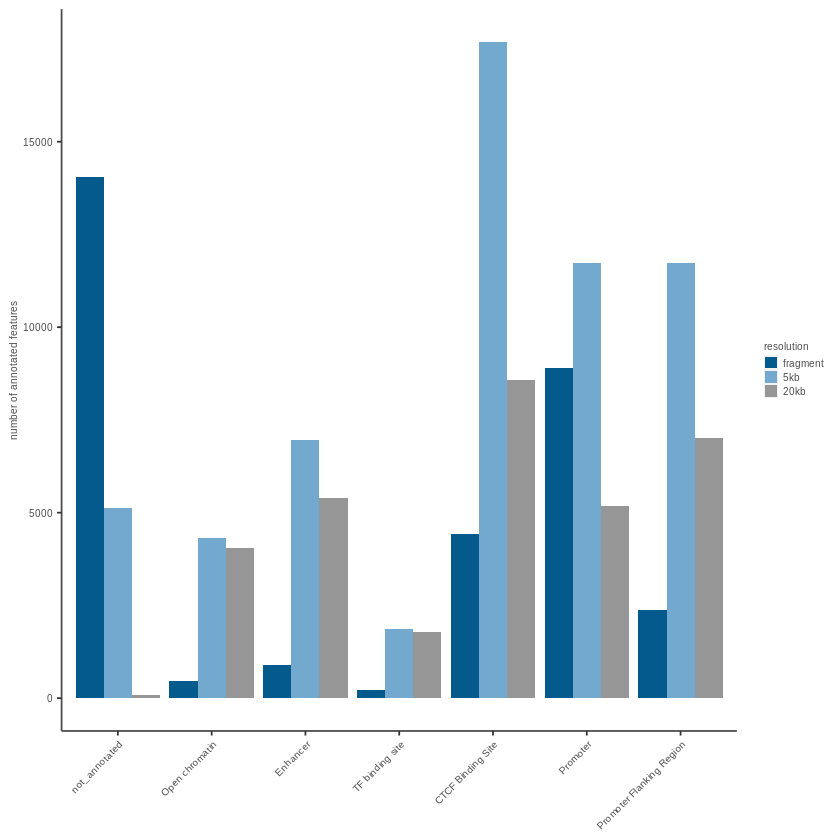

In [5]:
p

In [6]:
## annotating active and/or open ILC PIRs with blueprint feature types

# fragment res
ilc_fres_actx_bp <- merge(unique(ilc_fres_x[atac == TRUE | k27ac == TRUE][,c("otherEndID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("fres_ID", "Feature_type")]), 
                       by.x = "otherEndID", by.y = "fres_ID", all.x = TRUE)

# 5kb res
ilc_5kb_actx_bp <- merge(unique(ilc_5kb_x[atac == TRUE | k27ac == TRUE][,c("otherEndID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("5kb_ID", "Feature_type")]), 
                       by.x = "otherEndID", by.y = "5kb_ID", all.x = TRUE)

# 20kb res
ilc_20kb_actx_bp <- merge(unique(ilc_20kb_x[atac == TRUE | k27ac == TRUE][,c("otherEndID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("20kb_ID", "Feature_type")]), 
                       by.x = "otherEndID", by.y = "20kb_ID", all.x = TRUE)


## counting Feature types
bp_ilc_fres_act <- ilc_fres_actx_bp[,.N, by = "Feature_type"]
bp_ilc_5kb_act <- ilc_5kb_actx_bp[,.N, by = "Feature_type"]
bp_ilc_20kb_act <- ilc_20kb_actx_bp[,.N, by = "Feature_type"]


bp_ilc_fres_act[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]
bp_ilc_5kb_act[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]
bp_ilc_20kb_act[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]

bp_ilc_fres_act[,resolution := "fragment"]
bp_ilc_5kb_act[,resolution := "5kb"]
bp_ilc_20kb_act[,resolution := "20kb"]

In [7]:
bp_ilc_act_ressum <- rbind(bp_ilc_fres_act, bp_ilc_5kb_act, bp_ilc_20kb_act)

## plotting

bp_ilc_act_ressum$Feature_type <- factor(bp_ilc_act_ressum$Feature_type, 
                                     levels = c("not_annotated", 'Open chromatin', 'Enhancer', 'TF binding site',
                                               "CTCF Binding Site", "Promoter", "Promoter Flanking Region"))

bp_ilc_act_ressum$resolution <- factor(bp_ilc_act_ressum$resolution, 
                                     levels = c("fragment", '5kb', '20kb'))

p1 <- ggplot(bp_ilc_act_ressum, aes(fill=resolution, y=N, x=Feature_type)) + 
      geom_bar(position="dodge", stat="identity") +
      scale_fill_manual(values = c("fragment" = "#045a8d",
                                   "5kb"="#74a9cf",
                                   "20kb" = "#969696")) + 
      ylab("number of annotated features") +
      theme(axis.text.x = element_text(size = 6, angle = 45, vjust = 1, hjust=1),
            axis.title.x= element_blank(),
            axis.text.y = element_text(size = 6),
            axis.title.y = element_text(size = 6, colour = "grey30"),
            legend.title = element_text(size=6, colour = "grey30"),
            legend.text = element_text(size=6, colour = "grey30"),
            legend.key.width = unit(0.3, 'cm'),
            legend.key.height = unit(0.3, 'cm'),
            panel.background = element_rect(fill = "white"),
            axis.line.x=element_line(color="grey30"),
            axis.line.y=element_line(color="grey30")
            )

ggsave("~/miniPCHiC/hILCs/hILCs_run2/Chicago/ILC_act_PIRs_Blueprint_annotation.pdf", p1, width = 4, height = 3, useDingbats=FALSE)



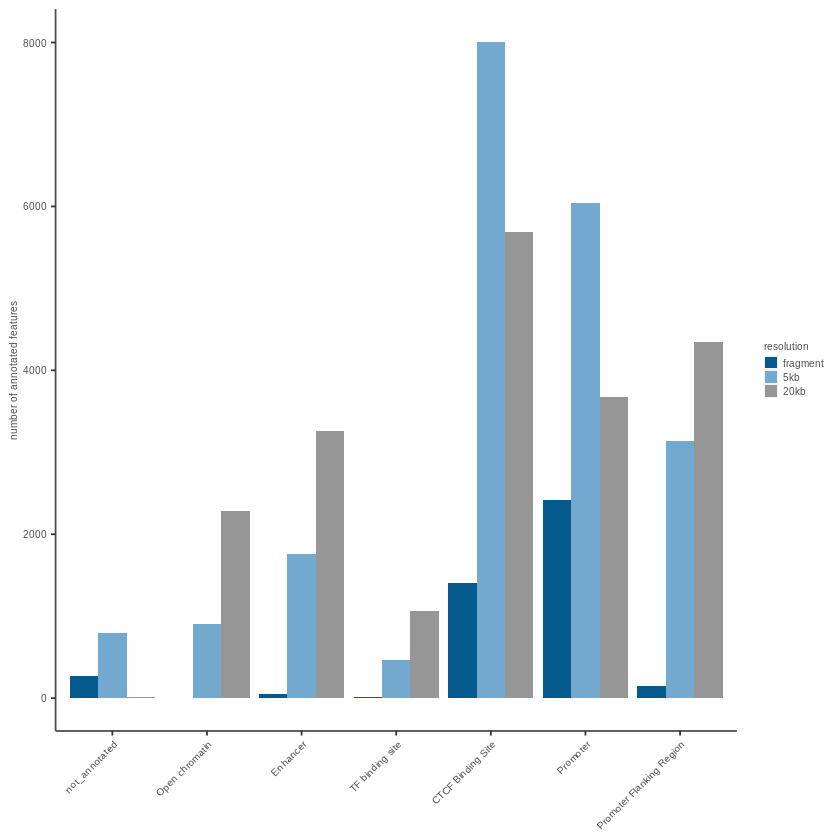

In [10]:
p1

In [2]:
### Blueprint on 5kb, fragment and consensus

### This script checks which interactions are marked by ATAC and H3K27ac at PIRs

library(data.table)
library(ggplot2)


# load epigenetic data

atac <- fread("/rds/general/user/malyshev/home/miniPCHiC/hILCs/spivakov_pchic_ILC_CD4/data/peaks/ATAC/ILC3_ATAC_peaks.bed")
k27ac <- fread("/rds/general/user/malyshev/home/miniPCHiC/hILCs/spivakov_pchic_ILC_CD4/data/peaks/CHIP/ILC3_H3K27ac_peaks.bed")

# load rmaps
rmap_fres <- fread("/rds/general/user/malyshev/home/spivakov_analysis_live/Design/Human_DpnII_binsize1500_maxL75K/hg38_dpnII.rmap")
rmap_5kb <- fread("/rds/general/user/malyshev/home/spivakov_analysis_live/Design/Human_hg38_bin5K_sol_baits/human_DpnII_5K_sol_baits.rmap")

## function for merging epigenetic data with rmap

epirmap <- function(epiprof, rmap_fres, rmap_5kb, overlap_by){
  
    # overlap_by: "summit" or "region"

    if (overlap_by == "summit"){
      # define middle point of a peak
      epiprof[,mid := (V2 + V3) /2]
      epiprof[,mid_2 := (V2 + V3) /2]
      epiprof <- epiprof[,c("V1", "V2", "V3", "mid", "mid_2")]
      epiprof[,V1 := gsub("chr", "", V1)]
    }else{
      # define range of a peak
      epiprof[,mid := V2]
      epiprof[,mid_2 := V3]
      epiprof <- epiprof[,c("V1", "V2", "V3", "mid", "mid_2")]
      epiprof[,V1 := gsub("chr", "", V1)]
    }


    # assign peaks to fres rmap bins by summit
    setkey(epiprof, V1, mid, mid_2)
    setkey(rmap_fres, V1, V2, V3)
    epi_rmap <- foverlaps(epiprof, rmap_fres, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))
    epi_rmap <- epi_rmap[,c("V1", "mid", "mid_2", "V4")]
    setnames(epi_rmap, "V4", "fres_ID")

    # assign peaks to 5kb rmap bins by summit
    setkey(epi_rmap, V1, mid, mid_2)
    setkey(rmap_5kb, V1, V2, V3)
    epi_rmap <- foverlaps(epi_rmap, rmap_5kb, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))
    epi_rmap <- epi_rmap[,c("V1", "mid", "mid_2", "fres_ID", "V4")]
    setnames(epi_rmap, "V4", "5kb_ID")
    
    return(epi_rmap)
}

atac_rmap <- epirmap(atac, rmap_fres, rmap_5kb, "summit")
k27ac_rmap <- epirmap(k27ac, rmap_fres, rmap_5kb, "summit")


In [52]:
## load the singificant interactions:
## the "sel" stands for score >=5
## loading ILC Chicago results
ilc_fres <- readRDS("~/miniPCHiC/hILCs/hILCs_run2/Chicago/without_binning/hILC3_all_merged_Step2_corrected_weighting/data/hILC3_all_merged_Step2_corrected_weighting.Rds")
ilc_5kb <- readRDS("~/miniPCHiC/hILCs/hILCs_run2/Chicago/with_binning/hILCs_all_merged_bin_Step2/data/hILCs_all_merged_bin_Step2.Rds")

### check if PIRs have ATAC or H3K27ac markers

ilc_fres_x <- ilc_fres@x[score >= 5][,atac := ifelse(otherEndID %in% atac_rmap$fres_ID, "TRUE", "FALSE")]
ilc_fres_x <- ilc_fres_x[,k27ac := ifelse(otherEndID %in% k27ac_rmap$fres_ID, "TRUE", "FALSE")]

ilc_5kb_x <- ilc_5kb@x[score >= 5][,atac := ifelse(otherEndID %in% atac_rmap$'5kb_ID', "TRUE", "FALSE")]
ilc_5kb_x <- ilc_5kb_x[,k27ac := ifelse(otherEndID %in% k27ac_rmap$'5kb_ID', "TRUE", "FALSE")]

## mark PIRs that have ATAC or H3K27ac peaks

print("total number of interactions")
nrow(ilc_fres_x) # 31003
print("total number of unique PIRs")
length(unique(ilc_fres_x$otherEndID)) # 28174
print("number of unique fragres PIRs marked with ATAC")
length(unique(ilc_fres_x[atac == TRUE]$otherEndID)) # 2614
print("number of unique fragres PIRs marked with H3K27ac")
length(unique(ilc_fres_x[k27ac == TRUE]$otherEndID)) # 1089
print("number of unique fragres PIRs marked with H3K27ac or ATAC")
length(unique(ilc_fres_x[k27ac == TRUE | atac == TRUE]$otherEndID)) # 3095

# 5kb resolution

print("total number of 5kb unique interactions")
nrow(unique(ilc_5kb_x)) # 58632
print("total number of unique PIRs")
length(unique(ilc_5kb_x$otherEndID)) # 35812
print("number of 5kb PIRs marked with ATAC")
length(unique(ilc_5kb_x[atac == TRUE]$otherEndID)) # 10617
print("number of 5kb PIRs marked with H3K27ac")
length(unique(ilc_5kb_x[k27ac == TRUE]$otherEndID)) # 4043
print("number of 5kb PIRs marked with H3K27ac or ATAC")
length(unique(ilc_5kb_x[k27ac == TRUE | atac == TRUE]$otherEndID)) # 11822


[1] "total number of interactions"


[1] 31003

[1] "total number of unique PIRs"


[1] 28174

[1] "number of unique fragres PIRs marked with ATAC"


[1] 2614

[1] "number of unique fragres PIRs marked with H3K27ac"


[1] 1089

[1] "number of unique fragres PIRs marked with H3K27ac or ATAC"


[1] 3095

[1] "total number of 5kb unique interactions"


[1] 58632

[1] "total number of unique PIRs"


[1] 35812

[1] "number of 5kb PIRs marked with ATAC"


[1] 10617

[1] "number of 5kb PIRs marked with H3K27ac"


[1] 4043

[1] "number of 5kb PIRs marked with H3K27ac or ATAC"


[1] 11822

In [46]:
#### integrate with blueprint
library(data.table)
regbuild <- fread("~/spivakov_analysis_live/ensembl/Ensembl96_GRCh38_RegBuild.txt")


### regbuild open or active with ALL bins overlapping the feature (enhancer or open chromatin) marked as containing it

bp_all <- regbuild
colnames(bp_all) <- c("V1", "V2", "V3", "Feature_type", "feature_type_dscr")
bp_all_rmap <- epirmap(bp_all, rmap_fres, rmap_5kb, "region")


bp_all_rmap_annot <- merge(bp_all_rmap, bp_all, by.x = c("V1", "mid", "mid_2"), by.y = c("V1", "V2", "V3"))

## annotating ILC PIRs with blueprint feature types

# fragment res
ilc_fres_x_bp <- merge(unique(ilc_fres_x[,c("otherEndID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("fres_ID", "Feature_type")]), 
                       by.x = "otherEndID", by.y = "fres_ID", all.x = TRUE)

# 5kb res
ilc_5kb_x_bp <- merge(unique(ilc_5kb_x[,c("otherEndID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("5kb_ID", "Feature_type")]), 
                       by.x = "otherEndID", by.y = "5kb_ID", all.x = TRUE)

# ## counting Feature types
# bp_ilc_fres <- ilc_fres_x_bp[,.N, by = c("Feature_type", ]
# bp_ilc_5kb <- ilc_5kb_x_bp[,.N, by = "Feature_type"]

# bp_ilc_fres[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]
# bp_ilc_5kb[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]

# bp_ilc_fres[,resolution := "fragment"]
# bp_ilc_5kb[,resolution := "5kb"]


In [2]:
### annotating the chicago consensus set

### This script checks which interactions are marked by ATAC and H3K27ac at PIRs

library(data.table)
library(Chicago)
library(ggplot2)
library(eulerr)

consensus <- fread("~/miniPCHiC/hILCs/rcogs/git_hILCs_COGS/ILC3_chicago_fres_5kb_abc_fres_extended_peakm.txt")

Warning message:
“package ‘Chicago’ was built under R version 3.6.3”
Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”


Welcome to CHiCAGO - version 1.14.0

If you are new to CHiCAGO, please consider reading the vignette through the command: vignette("Chicago").

NOTE: Default values of tlb.minProxOEPerBin and tlb.minProxB2BPerBin changed as of Version 1.1.5. No action is required unless you specified non-default values, or wish to re-run the pipeline on old chicagoData objects. See news(package="Chicago")



In [7]:
chicago_consensus <- consensus[chicago_fres >= 5 | chicago_5kb >= 5][,atac := ifelse(oeID %in% atac_rmap$fres_ID, "TRUE", "FALSE")]
chicago_consensus <- chicago_consensus[,k27ac := ifelse(oeID %in% k27ac_rmap$fres_ID, "TRUE", "FALSE")]

chicago_consensus_bp <- merge(unique(chicago_consensus[,c("oeID", "atac", "k27ac")]), unique(bp_all_rmap_annot[,c("fres_ID", "Feature_type")]), 
                       by.x = "oeID", by.y = "fres_ID", all.x = TRUE)


In [9]:

chicago_consensus_bp[,atac_k27ac := ifelse((atac == TRUE | k27ac == TRUE), "TRUE", "FALSE")]
# ilc_fres_x_bp[,atac_k27ac := ifelse((atac == TRUE | k27ac == TRUE), "TRUE", "FALSE")]
# ilc_5kb_x_bp[,atac_k27ac := ifelse((atac == TRUE | k27ac == TRUE), "TRUE", "FALSE")]

chicago_consensus_bp[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]
# ilc_fres_x_bp[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]
# ilc_5kb_x_bp[,Feature_type := ifelse(is.na(Feature_type), "not_annotated", Feature_type)]


In [1]:
nrow(chicago_consensus)
nrow(chicago_consensus[atac == TRUE | k27ac == TRUE])
nrow(chicago_consensus[atac_k27ac == TRUE])

ERROR: Error in nrow(chicago_consensus): object 'chicago_consensus' not found


In [11]:
35580/932907

[1] 0.03813885

In [14]:
head(chicago_consensus_bp)

oeID,atac,k27ac,Feature_type,atac_k27ac
<int>,<chr>,<chr>,<chr>,<chr>
2009,FALSE,FALSE,CTCF Binding Site,FALSE
2010,FALSE,FALSE,CTCF Binding Site,FALSE
2011,FALSE,FALSE,CTCF Binding Site,FALSE
2012,FALSE,FALSE,CTCF Binding Site,FALSE
2013,FALSE,FALSE,CTCF Binding Site,FALSE
2014,FALSE,FALSE,not_annotated,FALSE


In [15]:
# ilc_fres_x_bp <- ilc_fres_x_bp[,.N, by = c("Feature_type", "atac_k27ac")]
# ilc_5kb_x_bp <- ilc_5kb_x_bp[,.N, by = c("Feature_type", "atac_k27ac")]
chicago_consensus_bp <- chicago_consensus_bp[,.N, by = c("Feature_type", "atac_k27ac")]

chicago_consensus_bp[,resolution := "chicago_consensus"]
# ilc_fres_x_bp[,resolution := "chicago_fragment_resolution"]
# ilc_5kb_x_bp[,resolution := "chicago_5kb_resolution"]

In [68]:
bp_ilc_ressum <- rbind(ilc_fres_x_bp, ilc_5kb_x_bp, chicago_consensus_bp)

## plotting

bp_ilc_ressum$Feature_type <- factor(bp_ilc_ressum$Feature_type, 
                                     levels = c("not_annotated", 'Open chromatin', 'Enhancer', 'TF binding site',
                                               "CTCF Binding Site", "Promoter", "Promoter Flanking Region"))

bp_ilc_ressum$resolution <- factor(bp_ilc_ressum$resolution, 
                                     levels = c("chicago_fragment_resolution", 'chicago_5kb_resolution', 'chicago_consensus'))

p <- ggplot(bp_ilc_ressum, aes(fill=atac_k27ac, y=N, x=resolution)) + 
      geom_bar(position="stack", stat="identity") +
#       scale_fill_manual(values = c("chicago_fragment_resolution" = "#045a8d",
#                                    "chicago_5kb_resolution"="#74a9cf",
#                                    "chicago_consensus" = "#969696")) + 
    facet_grid(~ Feature_type) + 
      ylab("number of annotated features") +
      theme(axis.text.x = element_text(size = 6, angle = 45, vjust = 1, hjust=1),
            axis.title.x= element_blank(),
            axis.text.y = element_text(size = 6),
            axis.title.y = element_text(size = 6, colour = "grey30"),
            legend.title = element_text(size=6, colour = "grey30"),
            legend.text = element_text(size=6, colour = "grey30"),
            legend.key.width = unit(0.3, 'cm'),
            legend.key.height = unit(0.3, 'cm'),
            panel.background = element_rect(fill = "white"),
            axis.line.x=element_line(color="grey30"),
            axis.line.y=element_line(color="grey30")
            )

# ggsave("~/miniPCHiC/hILCs/hILCs_run2/Chicago/ILC_PIRs_Blueprint_annotation.pdf", p, width = 4, height = 3, useDingbats=FALSE)



ERROR: Error in geom_bar_pattern(stat = "identity", pattern_color = "white", : could not find function "geom_bar_pattern"


In [25]:
chicago_consensus_bp$Feature_type <- factor(chicago_consensus_bp$Feature_type, 
                                     levels = c("not_annotated", 'Open chromatin', 'Enhancer', 'TF binding site',
                                               "CTCF Binding Site", "Promoter", "Promoter Flanking Region"))


In [33]:
p <- ggplot(chicago_consensus_bp[atac_k27ac == "TRUE"], aes(y=N, x=Feature_type, fill = "#fdae61")) + 
      geom_bar(position="stack", stat="identity") +
#       scale_fill_manual(values = c("chicago_fragment_resolution" = "#045a8d",
#                                    "chicago_5kb_resolution"="#74a9cf",
#                                    "chicago_consensus" = "#969696")) + 
      ylab("number of annotated features") +
      theme(axis.text.x = element_text(size = 6, angle = 45, vjust = 1, hjust=1),
            axis.title.x= element_blank(),
            axis.text.y = element_text(size = 6),
            axis.title.y = element_text(size = 6, colour = "grey30"),
            legend.title = element_text(size=6, colour = "grey30"),
            legend.text = element_text(size=6, colour = "grey30"),
            legend.key.width = unit(0.3, 'cm'),
            legend.key.height = unit(0.3, 'cm'),
            panel.background = element_rect(fill = "white"),
            axis.line.x=element_line(color="grey30"),
            axis.line.y=element_line(color="grey30")
            )



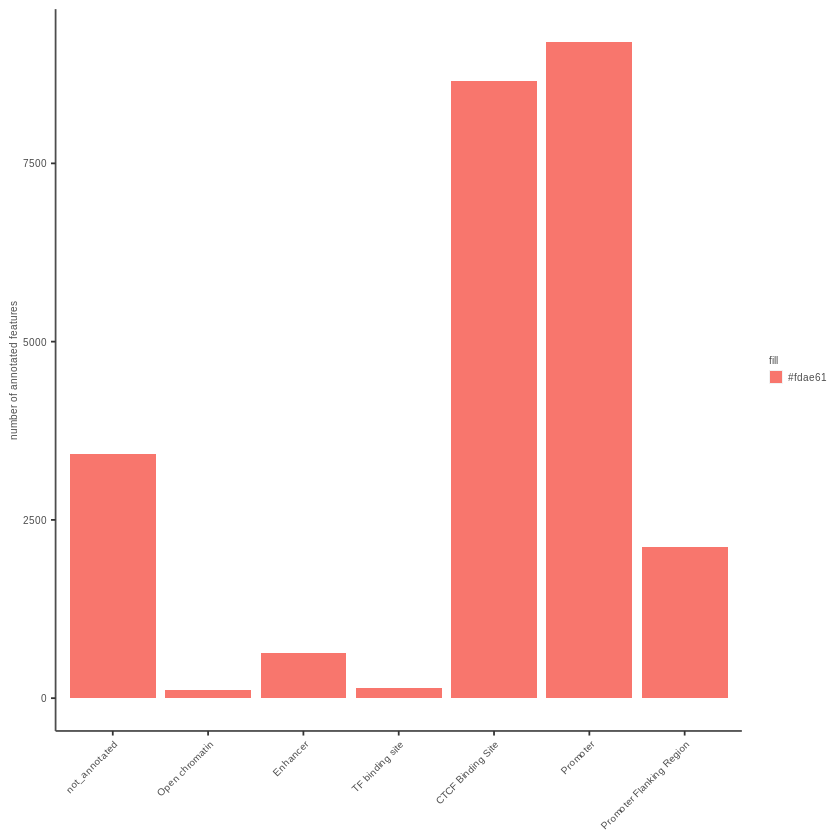

In [37]:
p

In [35]:
ggsave("~/miniPCHiC/hILCs/hILCs_run2/git_hILCs_PCHiC/ILC_merged_act_PIRs_Blueprint_annotation.pdf", p, width = 2.5, height = 3, useDingbats=FALSE)


In [38]:
ilc_abc_re <- fread("~/miniPCHiC/hILCs/spivakov_pchic_ILC_CD4/data/outputs/expression_analysis/ILC_5kb_within_newbmap_CHiCAGO_ABC_peakm_RE.tsv")


In [39]:
head(chicago_consensus)

baitChr,baitStart,baitEnd,baitID,baitName,oeChr,oeStart,oeEnd,oeID,oeName,baitID_5kb,oeID_5kb,dist,chicago_fres,chicago_5kb,ABC.Score,atac,k27ac
<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,995927,1000058,2052,HES4,1,989911,990058,2027,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,990059,990235,2028,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,990236,990776,2029,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,990777,991054,2030,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,991055,991149,2031,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE
1,995927,1000058,2052,HES4,1,991150,991423,2032,,173,171,-5475,NA,5.148217,NA,FALSE,FALSE


Warning message:
“Removed 81 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 82 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 81 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 82 rows containing non-finite values (stat_summary).”


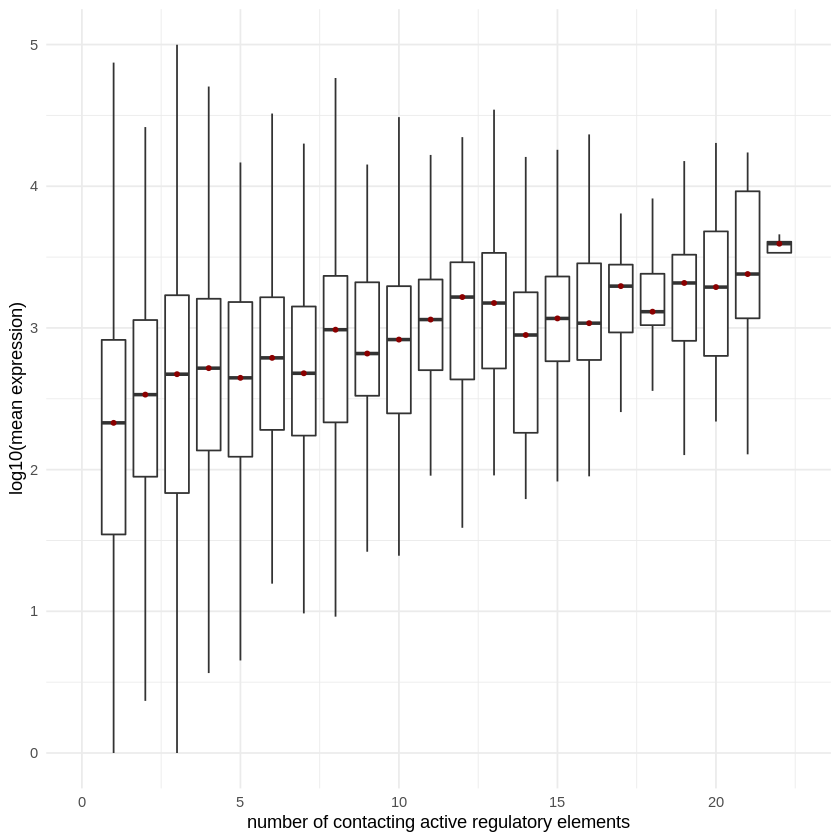

In [70]:
consensus_actop_pirs <- unique(chicago_consensus[atac == TRUE | k27ac == TRUE])[, c("baitName", "baitID", "oeID")]

consensus_actop_pirs_ge <- merge(consensus_actop_pirs, ilc_abc_re[,c("Gene_Name", "Mean_Gene_Expression")], 
                      by.x = c("baitName"), by.y = c("Gene_Name"), all.x = TRUE)

consensus_actop_pirs_ge <- consensus_actop_pirs_ge[!is.na(Mean_Gene_Expression)]
consensus_actop_pirs_ge_sum <- consensus_actop_pirs_ge[,.N, by = c("baitName", "Mean_Gene_Expression")]

p1 <- ggplot(consensus_actop_pirs_ge_sum, aes(N, log(Mean_Gene_Expression,10))) +
        geom_boxplot(aes(group = cut_width(N, 1)), outlier.alpha = 0) +
        ylim(0,5) + xlim(0,22.5) + 
        theme_minimal() +
        stat_summary(fun=median, geom="point",colour="darkred", size=1) +
        xlab("number of contacting active regulatory elements") + ylab("log10(mean expression)")

p1
ggsave("~/miniPCHiC/hILCs/gene_expression_vs_contacts/ILC_merged_actop_PIRs_GE.pdf", p1, width = 2.5, height = 3.5, useDingbats=FALSE)


In [71]:
cor(consensus_actop_pirs_ge_sum$N, consensus_actop_pirs_ge_sum$Mean_Gene_Expression, method = "spearman")

[1] 0.3278699

Warning message:
“Removed 2 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”


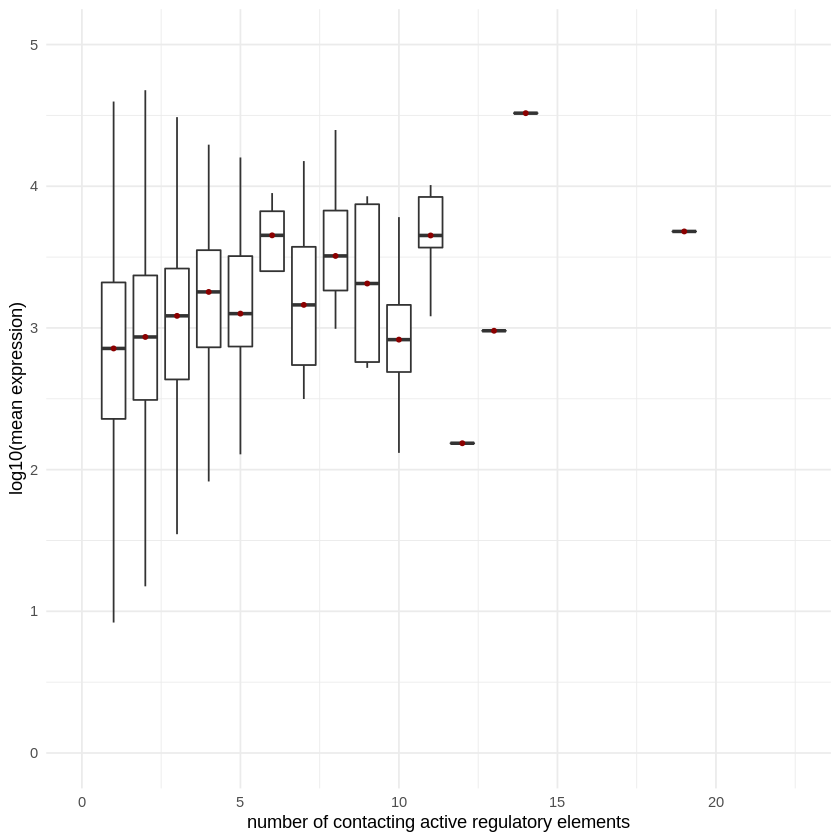

In [69]:
consensus_actandop_pirs <- unique(chicago_consensus[atac == TRUE & k27ac == TRUE])[, c("baitName", "baitID", "oeID")]

consensus_actandop_pirs_ge <- merge(consensus_actandop_pirs, ilc_abc_re[,c("Gene_Name", "Mean_Gene_Expression")], 
                      by.x = c("baitName"), by.y = c("Gene_Name"), all.x = TRUE)

consensus_actandop_pirs_ge <- consensus_actandop_pirs_ge[!is.na(Mean_Gene_Expression)]
consensus_actandop_pirs_ge_sum <- consensus_actandop_pirs_ge[,.N, by = c("baitName", "Mean_Gene_Expression")]

p2 <- ggplot(consensus_actandop_pirs_ge_sum, aes(N, log(Mean_Gene_Expression,10))) +
        geom_boxplot(aes(group = cut_width(N, 1)), outlier.alpha = 0) +
        ylim(0,5) + xlim(0,22.5) + 
        theme_minimal() +
        stat_summary(fun=median, geom="point",colour="darkred", size=1) +
        xlab("number of contacting active regulatory elements") + ylab("log10(mean expression)")

p2
ggsave("~/miniPCHiC/hILCs/gene_expression_vs_contacts/ILC_merged_actandop_PIRs_GE.pdf", p2, width = 2.5, height = 3, useDingbats=FALSE)


Warning message:
“Removed 81 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 82 rows containing non-finite values (stat_summary).”


In [98]:
p1 <- ggplot(bp_ilc_ressum[atac_k27ac == TRUE], aes(fill=resolution, y=N, x=Feature_type)) + 
      geom_bar(position="dodge", stat="identity") +
      scale_fill_manual(values = c("chicago_fragment_resolution" = "#045a8d",
                                   "chicago_5kb_resolution"="#74a9cf",
                                   "chicago_consensus" = "#969696")) + 
      ylab("number of annotated features") +
      theme(axis.text.x = element_text(size = 6, angle = 45, vjust = 1, hjust=1),
            axis.title.x= element_blank(),
            axis.text.y = element_text(size = 6),
            axis.title.y = element_text(size = 6, colour = "grey30"),
            legend.title = element_text(size=6, colour = "grey30"),
            legend.text = element_text(size=6, colour = "grey30"),
            legend.key.width = unit(0.3, 'cm'),
            legend.key.height = unit(0.3, 'cm'),
            panel.background = element_rect(fill = "white"),
            axis.line.x=element_line(color="grey30"),
            axis.line.y=element_line(color="grey30")
            )

# ggsave("~/miniPCHiC/hILCs/hILCs_run2/Chicago/ILC_PIRs_Blueprint_annotation.pdf", p, width = 4, height = 3, useDingbats=FALSE)



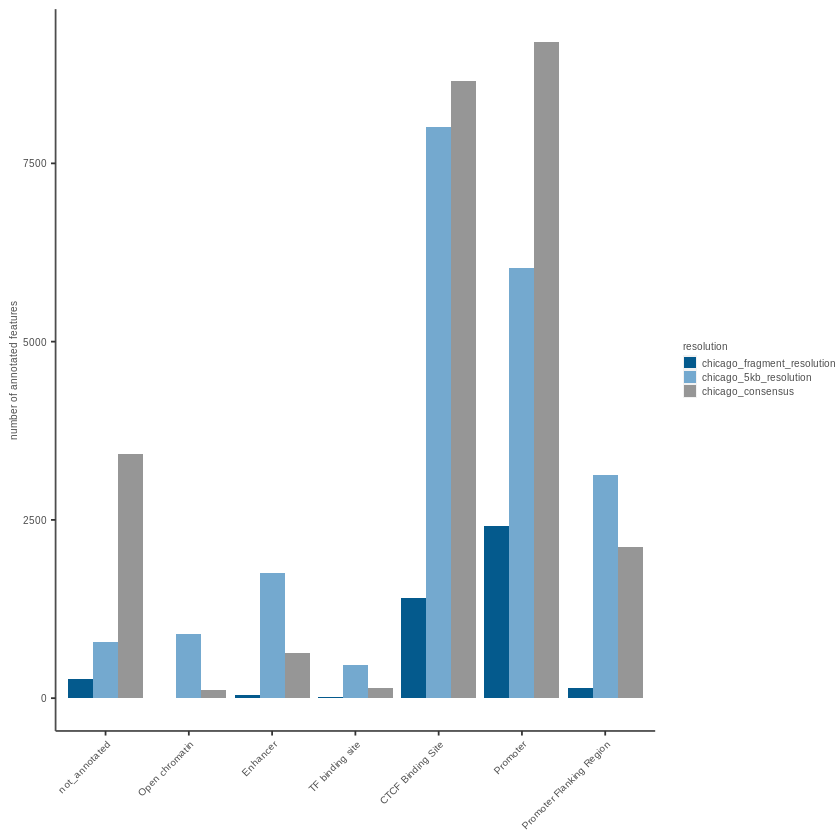

In [99]:
p1

In [96]:
p3 <- ggplot(bp_ilc_ressum[resolution != "chicago_consensus"], aes(fill=atac_k27ac, y=N, x=resolution)) + 
      geom_bar(position="stack", stat="identity") +
#       scale_fill_manual(values = c("chicago_fragment_resolution" = "#045a8d",
#                                    "chicago_5kb_resolution"="#74a9cf",
#                                    "chicago_consensus" = "#969696")) + 
     scale_fill_manual(values = c("TRUE" = "tomato3",
                                   "FALSE"="#045a8d")) + 
    facet_grid(~ Feature_type) + 
      ylab("number of annotated features") +
      theme(axis.text.x = element_text(size = 6, angle = 45, vjust = 1, hjust=1),
            axis.title.x= element_blank(),
            axis.text.y = element_text(size = 6),
            axis.title.y = element_text(size = 6, colour = "grey30"),
            legend.title = element_text(size=6, colour = "grey30"),
            legend.text = element_text(size=6, colour = "grey30"),
            legend.key.width = unit(0.3, 'cm'),
            legend.key.height = unit(0.3, 'cm'),
            panel.background = element_rect(fill = "white"),
            axis.line.x=element_line(color="grey30"),
            axis.line.y=element_line(color="grey30")
            )




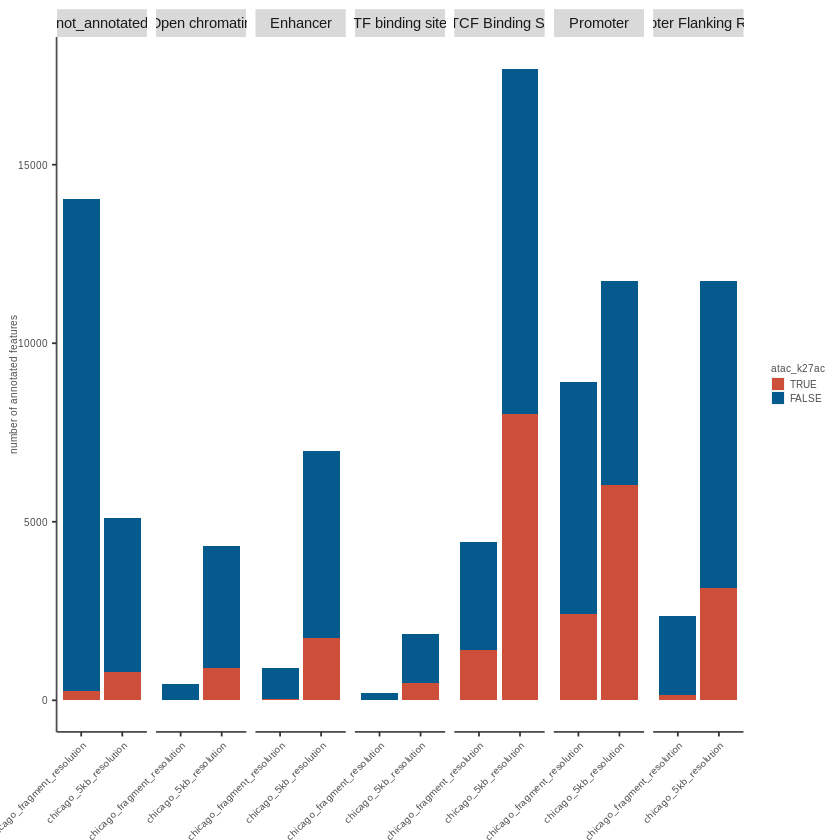

In [97]:
p3

In [103]:
nrow(chicago_consensus[(ABC.Score >=5 & chicago_5kb >=5) | (ABC.Score >=5 & chicago_fres >=5)])

[1] 3289

In [104]:
head(ilc_5kb_x)

baitID,otherEndID,distbin,s_j,otherEndLen,distSign,isBait2bait,N.1,N.2,N.3,⋯,tlb,tblb,Tmean,Bmean,log.p,log.w,log.q,score,atac,k27ac
<int>,<int>,<fct>,<dbl>,<int>,<int>,<lgl>,<int>,<int>,<int>,⋯,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
173,171,"(0,2e+04]",0.5967814,5214,-5475,FALSE,31,21,41,⋯,"(62,226]","[ 317, 357)",0.002170325,11.1585324,-5.148224,7.604980,-12.75320,5.148217,FALSE,FALSE
179,229906,NA,0.9481301,1079,NA,TRUE,0,0,6,⋯,"(26,39]B2B","[ 750, 830)",0.001772935,0.0000000,-20.798445,-2.452860,-18.34559,10.740598,TRUE,FALSE
179,176,"(0,2e+04]",0.9481301,5186,-8712,FALSE,48,32,38,⋯,"(62,226]","[ 750, 830)",0.004232449,10.6999219,-7.256617,7.604963,-14.86158,7.256594,TRUE,FALSE
179,170,"(2e+04,4e+04]",0.9481301,5398,-26272,FALSE,20,3,13,⋯,"(62,226]","[ 750, 830)",0.004232449,3.4182392,-5.537329,7.604574,-13.14190,5.536916,FALSE,FALSE
179,254,"(2.8e+05,3e+05]",0.9481301,5062,290411,FALSE,2,1,6,⋯,"(28,35]","[ 750, 830)",0.001770231,0.5031257,-5.526849,7.416891,-12.94374,5.338753,FALSE,FALSE
234,206,"(1e+05,1.2e+05]",0.7835963,5303,-111691,FALSE,7,2,11,⋯,"(62,226]","[ 404, 451)",0.002566185,0.7996440,-9.850208,7.587667,-17.43787,9.832887,TRUE,FALSE
